Input dataset:
- training_data.csv

This notebook includes:
- Test for significance and FDR
- Feature correlation
- Violin plots (continuous features)
- Barplots (categorical features)
- PCA

# Import libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns

from scipy.stats import mannwhitneyu, chi2_contingency, fisher_exact
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.multitest import fdrcorrection

%matplotlib inline

# Define paths

In [2]:
# user = 'kathi'
user = 'DeaGogishvili'

Data_path = '/Users/' + user + '/Documents/GitHub/ExtracellularVesicles/Data'

# Import dataset

### Feature dataset (all EVs)

In [3]:
df = Data_path + '/MachineLearning/training_data.csv' 
df_all = pd.read_csv(df, sep=',', engine='python')

In [4]:
df_all

id    length  hydr_count  polar_count  molecular_weight     helix  \
0      Q92667  9.818582    0.376523     0.370986         16.793404  0.079734   
1      P62736  8.558421    0.427056     0.379310         15.574035  0.445623   
2      Q9H553  8.700440    0.471154     0.358173         15.735720  0.485577   
3      P0C7M7  9.179909    0.424138     0.379310         16.216178  0.320690   
4      P49703  7.651052    0.417910     0.402985         14.652697  0.328358   
...       ...       ...         ...          ...               ...       ...   
13712  Q9Y6F7  9.079485    0.386322     0.454713         16.100194  0.280961   
13713  P26368  8.891784    0.366316     0.429474         15.920828  0.178947   
13714  Q9BTX3  7.434628    0.514451     0.306358         14.472938  0.624277   
13715  A6NFC5  7.800900    0.560538     0.179372         14.739747  0.573991   
13716  A0PK05  8.103288    0.458182     0.323636         15.087871  0.316364   

           turn     sheet         A         C  ...  ww_domain  RAS_profile  \
0      0.805094  0.115172  0.079734  0.018826  ...          0            0   
1      0.347480  0.206897  0.076923  0.018568  ...          0            0   
2      0.375000  0.139423  0.072115  0.028846  ...          0            0   
3      0.448276  0.231034  0.058621  0.022414  ...          0            0   
4      0.477612  0.194030  0.099502  0.004975  ...          0            0   
...         ...       ...       ...       ...  ...        ...          ...   
13712  0.595194  0.123845  0.075786  0.020333  ...          0            0   
13713  0.604211  0.216842  0.056842  0.012632  ...          0            0   
13714  0.352601  0.023121  0.104046  0.011561  ...          0            0   
13715  0.300448  0.125561  0.121076  0.031390  ...          0            0   
13716  0.683636  0.000000  0.087273  0.021818  ...          0            0   

       EGF  RRM  coiled_coil  transmembrane  TMHMM  Polar_exposed  \
0        0    0            1              1      1       0.447738   
1        0    0            0              0      0       0.682540   
2        0    0            0              1      0       0.614286   
3        0    0            0              0      0       0.661111   
4        0    0            0              0      0       0.567010   
...    ...  ...          ...            ...    ...            ...   
13712    0    0            0              0      0       0.588757   
13713    0    1            0              0      0       0.621849   
13714    0    0            0              1      1       0.460674   
13715    0    0            0              1      1       0.310000   
13716    0    0            0              1      1       0.364078   

       Hydrophobic_exposed  EV  
0                 0.263651   1  
1                 0.111111   1  
2                 0.185714   1  
3                 0.088889   0  
4                 0.195876   0  
...                    ...  ..  
13712             0.242604   0  
13713             0.130252   1  
13714             0.382022   0  
13715             0.420000   0  
13716             0.412621   0  

[13717 rows x 96 columns]

In [5]:
EV_yes = df_all[df_all["EV"] == 1]
EV_no = df_all[df_all["EV"] == 0]

# Feature analysis

In [6]:
features_continuous = ['length', 'hydr_count', 'polar_count', 'molecular_weight',
       'helix', 'turn', 'sheet', 'A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K',
       'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y', 'thsa_netsurfp2',
       'tasa_netsurfp2', 'rhsa_netsurfp2', 'disorder', 'A_exposed',
       'C_exposed', 'D_exposed', 'E_exposed', 'F_exposed', 'G_exposed',
       'H_exposed', 'I_exposed', 'K_exposed', 'L_exposed', 'M_exposed',
       'N_exposed', 'P_exposed', 'Q_exposed', 'R_exposed', 'S_exposed',
       'T_exposed', 'V_exposed', 'W_exposed', 'Y_exposed',
       'Prob. of Solubility', 'Aggregation_propensity', 'Aromaticity',
       'Instability_index', 'Gravy', 'isoelectric_point', 'charge_at_7',
       'charge_at_5', 'Polar_exposed', 'Hydrophobic_exposed']

features_categorical = ['HSP', 'PTM_UP', 'Citrullination_UP', 'GPI-anchor_UP',
       'Lipoprotein_UP', 'Nitration_UP', 'Prenylation_UP', 'ISGylation_UP',
       'NEDDylation_UP', 'Acetylation_all', 'Glycosylation_all',
       'Methylation_all', 'Myristoylation_all', 'Nitrosylation_all',
       'Palmitoylation_all', 'Phosphorylation_all', 'SUMOylation_all',
       'Ubiquitination_all', 'PTM_MSD', 'Phosphorylation_MSD',
       'Glycosylation_MSD', 'Ubiquitination_MSD', 'SUMOylation_MSD',
       'Acetylation_MSD', 'Palmitoylation_MSD', 'Methylation_MSD',
       'coiled_coil', 'RAS_profile', 'ww_domain', 'EGF', 'RRM', 'transmembrane', 'TMHMM']

### Mann-Whitney U Test

In [7]:
# create Series to save p-values
p_vals = pd.Series(index=features_continuous, dtype="float64", name='p_value')

# calculate p-values using Mann-Whitney U Test
for i, feature in enumerate(features_continuous):
    
    stat, p = mannwhitneyu(EV_yes[feature], EV_no[feature]) # function return statistic and p-value
    p_vals[i] = p 

# calculate adjusted p-value (FDR correction)
rejected, p_vals_adj = fdrcorrection(p_vals)
# create Series to save adjusted p-values
p_vals_adj = pd.Series(data=p_vals_adj, index=features_continuous, name='p_value_adjusted')

In [8]:
# save both p-values in dataframe
p_vals_comb = pd.concat([p_vals, p_vals_adj], axis=1)
# sort by adjusted p-value
p_vals_comb = p_vals_comb.sort_values(by='p_value_adjusted')

In [9]:
# print adjusted p-values (readable)
for i in range(len(p_vals_comb)):
    print(p_vals_comb.index[i], 'p=%.5f' % (p_vals_comb.p_value_adjusted[i]))

D_exposed p=0.00000
Instability_index p=0.00000
length p=0.00000
molecular_weight p=0.00000
Polar_exposed p=0.00000
D p=0.00000
charge_at_7 p=0.00000
C p=0.00000
turn p=0.00000
Hydrophobic_exposed p=0.00000
E_exposed p=0.00000
S p=0.00000
L_exposed p=0.00000
sheet p=0.00000
rhsa_netsurfp2 p=0.00000
H p=0.00000
K_exposed p=0.00000
V p=0.00000
isoelectric_point p=0.00000
I p=0.00000
C_exposed p=0.00000
disorder p=0.00000
N_exposed p=0.00000
tasa_netsurfp2 p=0.00000
W_exposed p=0.00000
P p=0.00000
S_exposed p=0.00000
N p=0.00000
H_exposed p=0.00000
K p=0.00000
F_exposed p=0.00000
thsa_netsurfp2 p=0.00000
P_exposed p=0.00000
V_exposed p=0.00000
W p=0.00000
Prob. of Solubility p=0.00000
R p=0.00000
Y_exposed p=0.00000
I_exposed p=0.00000
M p=0.00000
R_exposed p=0.00000
E p=0.00000
G p=0.00000
polar_count p=0.00000
hydr_count p=0.00000
A p=0.00000
M_exposed p=0.00000
helix p=0.00000
Aggregation_propensity p=0.00000
Gravy p=0.00001
Y p=0.00001
Q_exposed p=0.00011
L p=0.00014
T p=0.00035
charg

### Fisher's exact test	

In [10]:
# create Series to save p-values
p_vals_cat = pd.Series(index=features_categorical, dtype="float64", name='p_value')

# calculate p-values using Fisher's exact test
for i, feature in enumerate(features_categorical):
    
    # get counts for each category
    A = sum(EV_yes[feature]) # EV & positive
    B = len(EV_yes[feature]) - sum(EV_yes[feature]) # EV & negative
    C = sum(EV_no[feature]) # no EV & positive
    D = len(EV_no[feature]) - sum(EV_no[feature]) # no EV & negative
    
    # create 2x2 contingency table of counts
    table = np.array([[A, B],
                      [C, D]])
    
    odds, p = fisher_exact(table, alternative='two-sided') # function return odds ratio and p-value
    p_vals_cat[i] = p 

# calculate adjusted p-value (FDR correction)
rejected, p_vals_adj_cat = fdrcorrection(p_vals_cat)
# create Series to save adjusted p-values
p_vals_adj_cat = pd.Series(data=p_vals_adj_cat, index=features_categorical, name='p_value_adjusted')

In [11]:
# save both p-values in dataframe
p_vals_comb_cat = pd.concat([p_vals_cat, p_vals_adj_cat], axis=1)
# sort by adjusted p-value
p_vals_comb_cat = p_vals_comb_cat.sort_values(by='p_value_adjusted')

In [12]:
# print adjusted p-values (readable)
for i in range(len(p_vals_comb_cat)):
    print(p_vals_comb_cat.index[i], 'p=%.5f' % (p_vals_comb_cat.p_value_adjusted[i]))

Palmitoylation_all p=0.00000
PTM_UP p=0.00000
Ubiquitination_all p=0.00000
Acetylation_all p=0.00000
Methylation_all p=0.00000
Nitrosylation_all p=0.00000
Phosphorylation_all p=0.00000
Acetylation_MSD p=0.00000
SUMOylation_MSD p=0.00000
Glycosylation_all p=0.00000
Lipoprotein_UP p=0.00000
Ubiquitination_MSD p=0.00000
EGF p=0.00000
Glycosylation_MSD p=0.00000
Prenylation_UP p=0.00000
Methylation_MSD p=0.00000
SUMOylation_all p=0.00000
coiled_coil p=0.00000
Phosphorylation_MSD p=0.00000
RAS_profile p=0.00000
ISGylation_UP p=0.00000
RRM p=0.00000
Nitration_UP p=0.00000
HSP p=0.00000
Myristoylation_all p=0.00000
Citrullination_UP p=0.00021
PTM_MSD p=0.00558
GPI-anchor_UP p=0.00883
ww_domain p=0.02243
NEDDylation_UP p=0.02401
TMHMM p=0.04268
transmembrane p=0.10450
Palmitoylation_MSD p=0.32119


### Feature correlation

In [13]:
# calculate pairwise correlation
corr_all = df_all.corr()

<ipython-input-14-85863265dc67>:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(corr_all, dtype=np.bool))


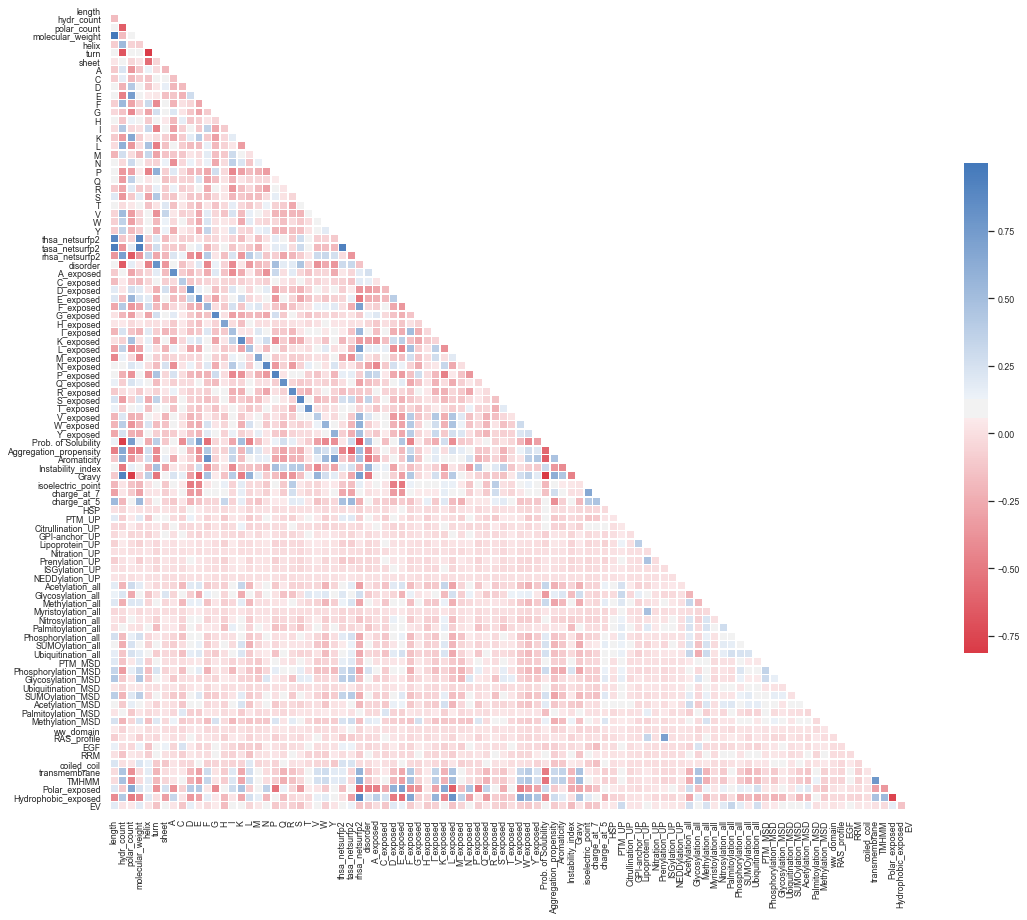

In [14]:
# figure settings
sns.set(font_scale=0.8)

mask = np.triu(np.ones_like(corr_all, dtype=np.bool))
sns.set_style(style = 'white')
fig, ax = plt.subplots(figsize=(18, 18))
cmap = sns.diverging_palette(10, 250, as_cmap=True)
sns.heatmap(corr_all, mask=mask, cmap=cmap, square=True, linewidths=.5, cbar_kws={"shrink": .5}, ax=ax,
            xticklabels=True, yticklabels=True);

#fig.savefig(Figure_path + '/EV/Feature_correlations_EV.png', dpi=150)

Text(0.5, 1.0, 'Correlation of features with EV')

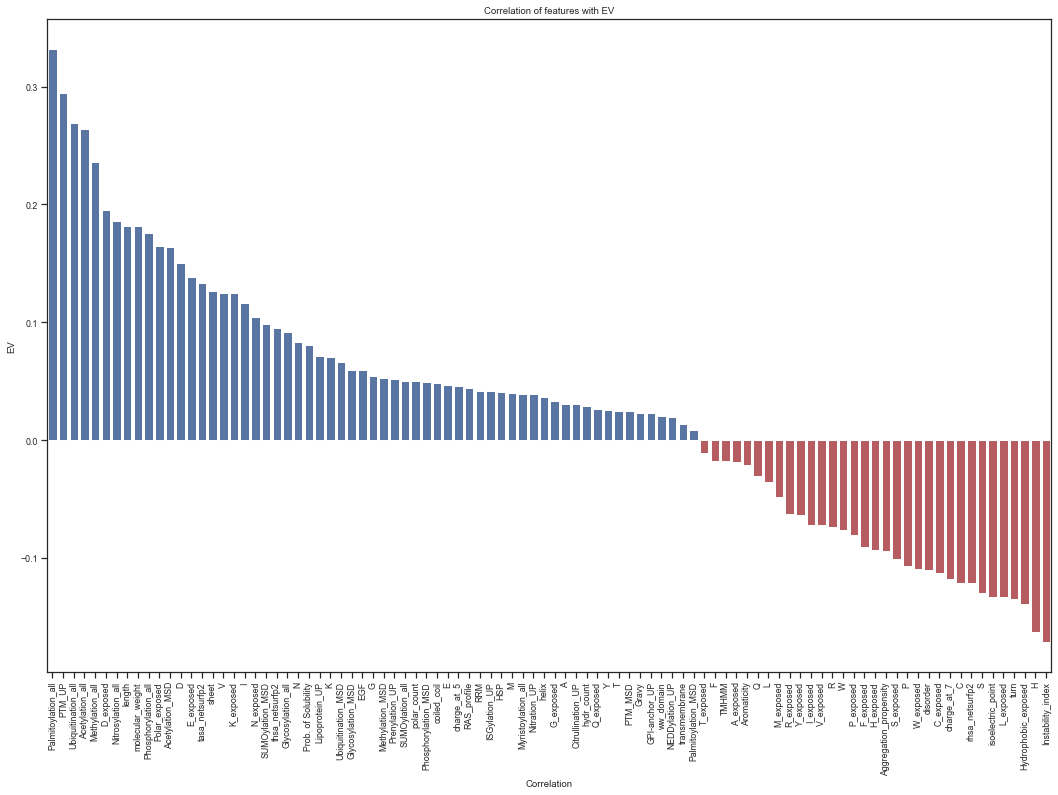

In [15]:
# figure settings
sns.set(style=("ticks"), font_scale=0.8)

correlations_all = corr_all[['EV']].sort_values(by="EV", ascending=False)[1:]
correlations_all.reset_index(inplace=True)

colors_all = ["b" if (x > 0) else "r" for x in correlations_all["EV"]]

fig = plt.figure(figsize=(18, 12)) 
sns.barplot(x="index", y="EV", data=correlations_all, palette=colors_all)
plt.xlabel("Features") 
plt.xticks(rotation=90)
plt.xlabel("Correlation")
plt.title("Correlation of features with EV")

#fig.savefig(Figure_path + '/EV/Feature_correlations_single_EV.png', dpi=150)

### Violin plots

In [16]:
# figure settings
sns.set(style=("ticks"), palette="Paired", font_scale=1.2)

#### Features of size (log2-transformed)

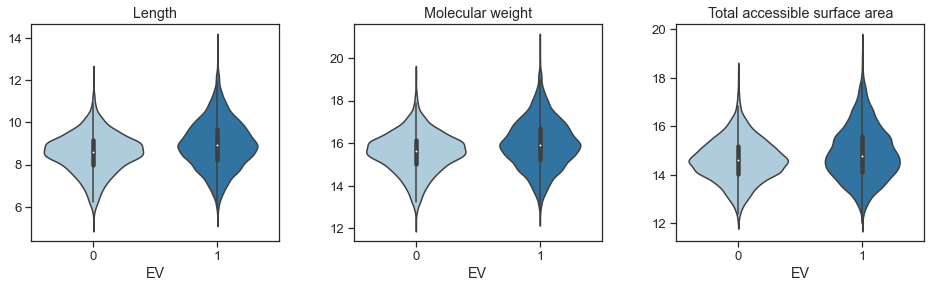

In [17]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=False, figsize=(16, 4))
sns.violinplot(x="EV", y='length', data=df_all, ax=ax1)
ax1.set(ylabel=None, title="Length")
sns.violinplot(x="EV", y='molecular_weight', data=df_all, ax=ax2)
ax2.set(ylabel=None, title="Molecular weight")
sns.violinplot(x="EV", y='tasa_netsurfp2', data=df_all, ax=ax3)
ax3.set(ylabel=None, title="Total accessible surface area")
plt.subplots_adjust(wspace = 0.3)
plt.show()
#fig.savefig(Figure_path + '/EV/Violin_plots_size_EV.png', dpi=150)

#### Physicochemical properties

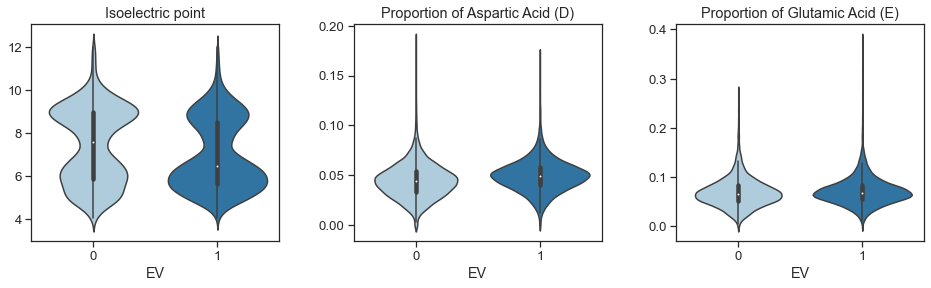

In [18]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=False, figsize=(16, 4))
sns.violinplot(x="EV", y='isoelectric_point', data=df_all, ax=ax1)
ax1.set(ylabel=None, title="Isoelectric point")
sns.violinplot(x="EV", y='D', data=df_all, ax=ax2)
ax2.set(ylabel=None, title="Proportion of Aspartic Acid (D)")
sns.violinplot(x="EV", y='E', data=df_all, ax=ax3)
ax3.set(ylabel=None, title="Proportion of Glutamic Acid (E)")
plt.subplots_adjust(wspace = 0.3)
plt.show()


#fig.savefig(Figure_path + '/EV/Violin_plots_physicochemical_1_EV.png', dpi=150)

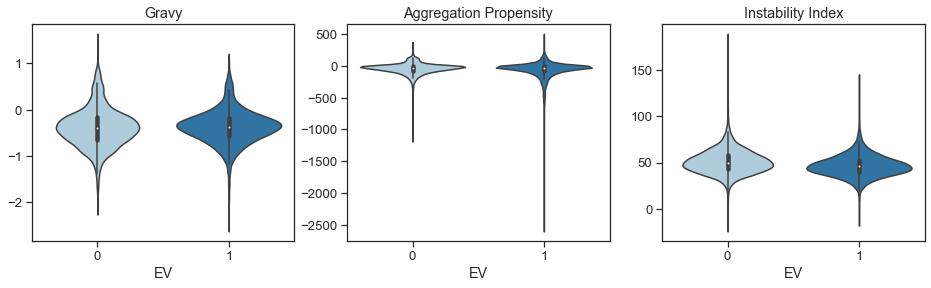

In [19]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=False, figsize=(16, 4))
sns.violinplot(x="EV", y='Gravy', data=df_all, ax=ax1)
ax1.set(ylabel=None, title="Gravy")
sns.violinplot(x="EV", y='Aggregation_propensity', data=df_all, ax=ax2)
ax2.set(ylabel=None, title="Aggregation Propensity")
sns.violinplot(x="EV", y='Instability_index', data=df_all, ax=ax3)
ax3.set(ylabel=None, title="Instability Index")
plt.show()

#fig.savefig(Figure_path + '/EV/Violin_plots_physicochemical_2_EV.png', dpi=150)

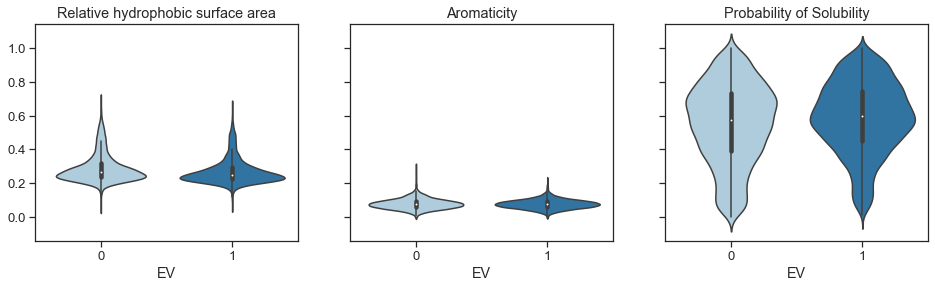

In [20]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(16, 4))
sns.violinplot(x="EV", y='rhsa_netsurfp2', data=df_all, ax=ax1)
ax1.set(ylabel=None, title="Relative hydrophobic surface area")
sns.violinplot(x="EV", y='Aromaticity', data=df_all, ax=ax2)
ax2.set(ylabel=None, title="Aromaticity")
sns.violinplot(x="EV", y='Prob. of Solubility', data=df_all, ax=ax3)
ax3.set(ylabel=None, title="Probability of Solubility")
plt.show()

#fig.savefig(Figure_path + '/EV/Violin_plots_physicochemical_3_EV.png', dpi=150)

#### Structural properties

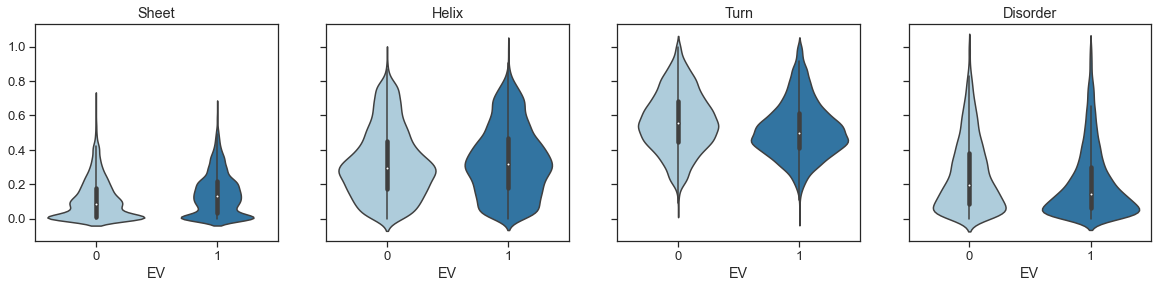

In [21]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharey=True, figsize=(20, 4))
sns.violinplot(x="EV", y='sheet', data=df_all, ax=ax1)
ax1.set(ylabel=None, title="Sheet")
sns.violinplot(x="EV", y='helix', data=df_all, ax=ax2)
ax2.set(ylabel=None, title="Helix")
sns.violinplot(x="EV", y='turn', data=df_all, ax=ax3)
ax3.set(ylabel=None, title="Turn")
sns.violinplot(x="EV", y='disorder', data=df_all, ax=ax4)
ax4.set(ylabel=None, title="Disorder")
plt.show()

#fig.savefig(Figure_path + '/EV/Violin_plots_structure_EV.png', dpi=150)

#### Amino acid composition

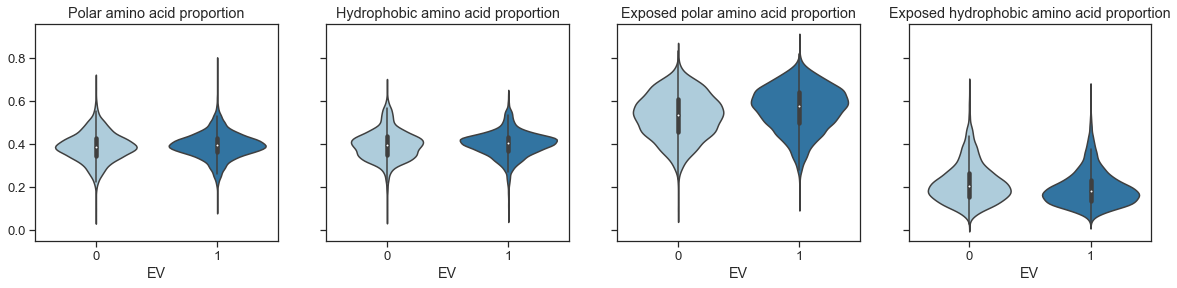

In [22]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharey=True, figsize=(20, 4))
sns.violinplot(x="EV", y='polar_count', data=df_all, ax=ax1)
ax1.set(ylabel=None, title="Polar amino acid proportion")
sns.violinplot(x="EV", y='hydr_count', data=df_all, ax=ax2)
ax2.set(ylabel=None, title="Hydrophobic amino acid proportion")
sns.violinplot(x="EV", y='Polar_exposed', data=df_all, ax=ax3)
ax3.set(ylabel=None, title="Exposed polar amino acid proportion")
sns.violinplot(x="EV", y='Hydrophobic_exposed', data=df_all, ax=ax4)
ax4.set(ylabel=None, title="Exposed hydrophobic amino acid proportion")
plt.show()

#fig.savefig(Figure_path + '/EV/Violin_plots_polar_hydr_AA_EV.png', dpi=150)

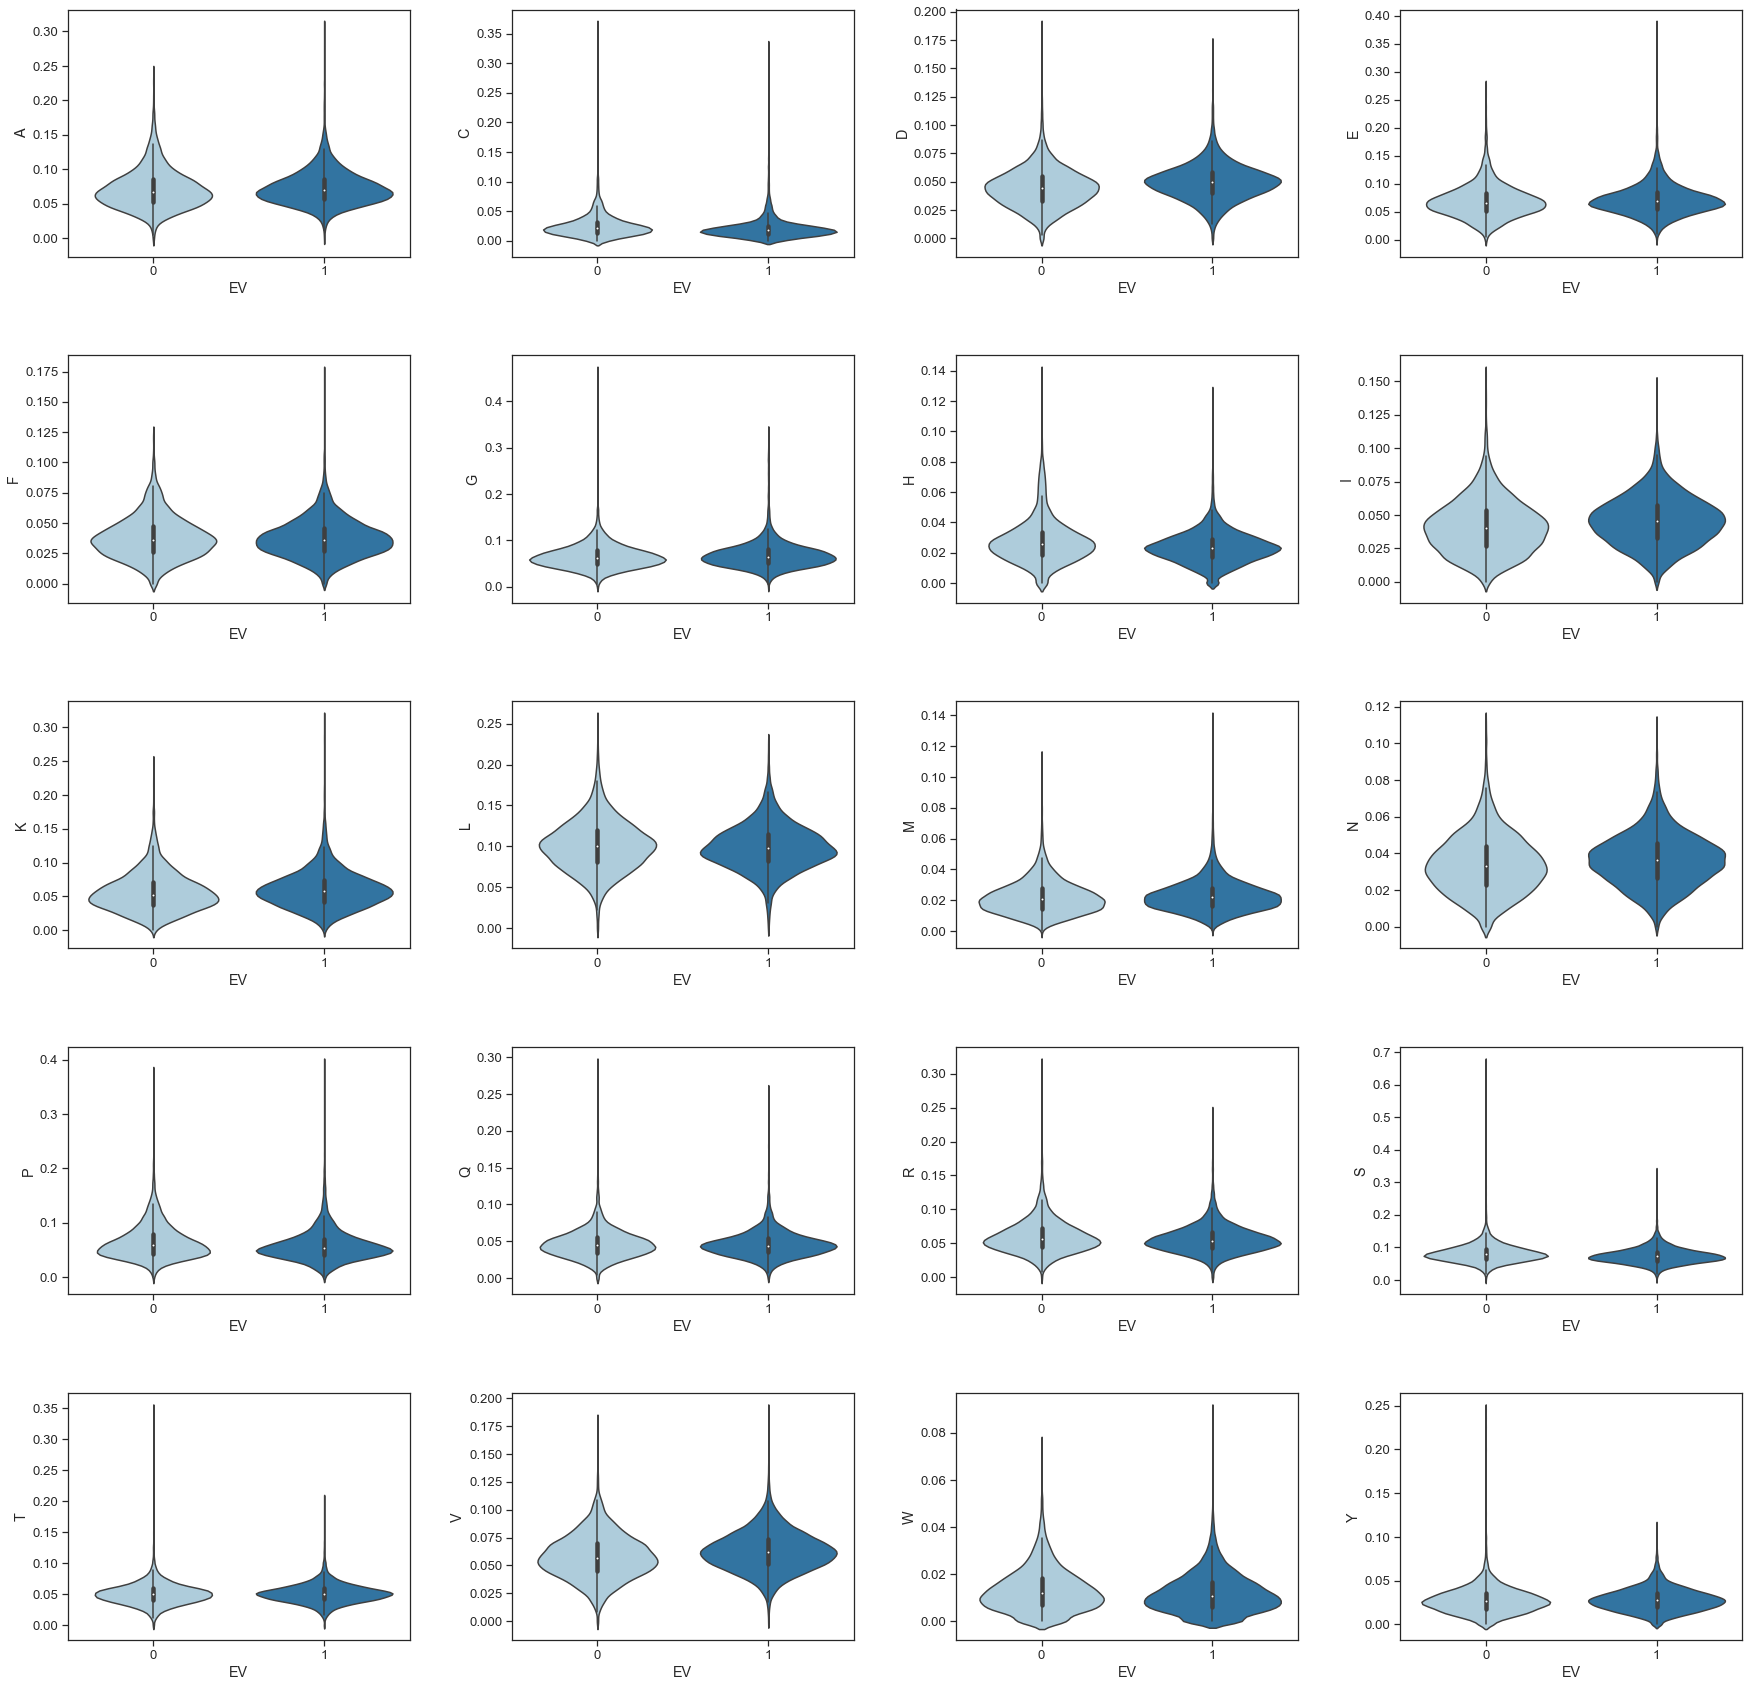

In [23]:
# figure settings
sns.set(style=("ticks"), palette="Paired", font_scale=1.2)

features_aa = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M',
       'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']

# create figure grid
fig = plt.figure(figsize=(30, 30))
grid = plt.GridSpec(5, 4, wspace=0.3, hspace=0.4)
plt.ylim((0,1))

counter = 0
for row_n in range(5):
    for col_n in range(4):
        if counter == 20:
            break
        row, col = row_n, col_n
        ax = plt.subplot(grid[row, col]) 
        sns.violinplot(x="EV", y=features_aa[counter], data=df_all, ax=ax, title=features_aa[counter])
        counter += 1
        
#fig.savefig(Figure_path + '/EV/Violin_plots_AA_EV.png', dpi=150)

#### Major PTMs

In [24]:
sns.set(style=("ticks"), palette="Paired", font_scale=1.2)

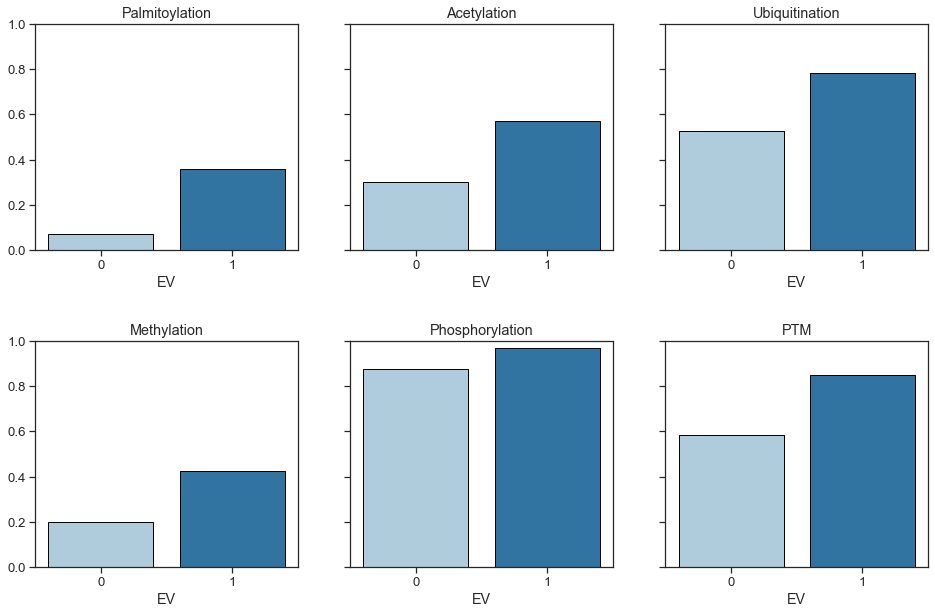

In [25]:
fig, axs = plt.subplots(2, 3, sharey=True, figsize=(16, 10))
plt.ylim((0,1))
sns.barplot(x="EV", y='Palmitoylation_all', data=df_all, ax=axs[0, 0], edgecolor="black", ci=None)
axs[0, 0].set(ylabel=None, title="Palmitoylation")
sns.barplot(x="EV", y='Acetylation_all', data=df_all, ax=axs[0, 1], edgecolor="black", ci=None)
axs[0, 1].set(ylabel=None, title="Acetylation")
sns.barplot(x="EV", y='Ubiquitination_all', data=df_all, ax=axs[0, 2], edgecolor="black", ci=None)
axs[0, 2].set(ylabel=None, title="Ubiquitination")
sns.barplot(x="EV", y='Methylation_all', data=df_all, ax=axs[1, 0], edgecolor="black", ci=None)
axs[1, 0].set(ylabel=None, title="Methylation")
sns.barplot(x="EV", y='Phosphorylation_all', data=df_all, ax=axs[1, 1], edgecolor="black", ci=None)
axs[1, 1].set(ylabel=None, title="Phosphorylation")
sns.barplot(x="EV", y='PTM_UP', data=df_all, ax=axs[1, 2], edgecolor="black", ci=None)
axs[1, 2].set(ylabel=None, title="PTM")
plt.subplots_adjust(hspace = 0.4)
plt.show()

#fig.savefig(Figure_path + '/EV/Bar_plots_PTM_1_EV.png', dpi=150)

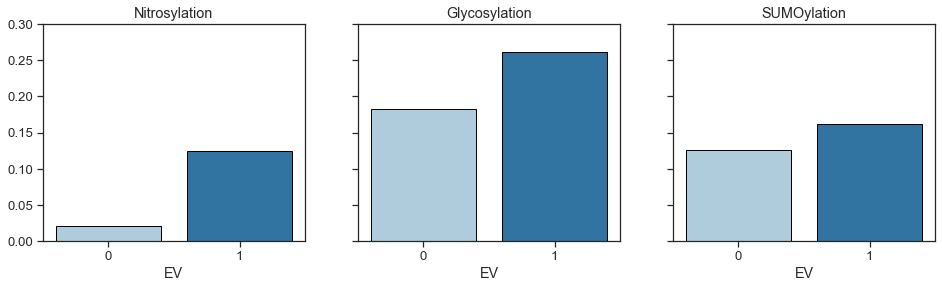

In [26]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(16, 4))
plt.ylim((0,0.3))
sns.barplot(x="EV", y='Nitrosylation_all', data=df_all, ax=ax1, edgecolor="black", ci=None)
ax1.set(ylabel=None, title="Nitrosylation")
sns.barplot(x="EV", y='Glycosylation_all', data=df_all, ax=ax2, edgecolor="black", ci=None)
ax2.set(ylabel=None, title="Glycosylation")
sns.barplot(x="EV", y='SUMOylation_all', data=df_all, ax=ax3, edgecolor="black", ci=None)
ax3.set(ylabel=None, title="SUMOylation")
plt.show()

#fig.savefig(Figure_path + '/EV/Bar_plots_PTM_2_EV.png', dpi=150)

#### Lipidation PTMs

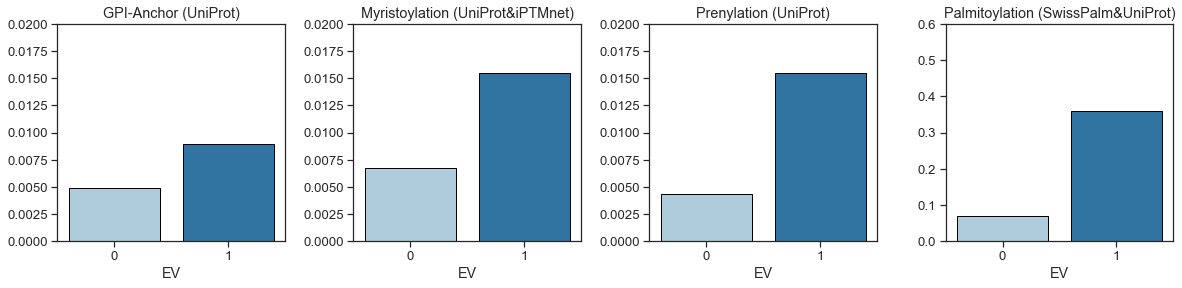

In [27]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 4))
sns.barplot(x="EV", y='GPI-anchor_UP', data=df_all, ax=ax1, edgecolor="black", ci=None)
ax1.set(ylabel=None, title="GPI-Anchor (UniProt)", ylim=(0, 0.02))
sns.barplot(x="EV", y='Myristoylation_all', data=df_all, ax=ax2, edgecolor="black", ci=None)
ax2.set(ylabel=None, title="Myristoylation (UniProt&iPTMnet)", ylim=(0, 0.02))
sns.barplot(x="EV", y='Prenylation_UP', data=df_all, ax=ax3, edgecolor="black", ci=None)
ax3.set(ylabel=None, title="Prenylation (UniProt)", ylim=(0, 0.02))
sns.barplot(x="EV", y='Palmitoylation_all', data=df_all, ax=ax4, edgecolor="black", ci=None)
ax4.set(ylabel=None, title="Palmitoylation (SwissPalm&UniProt)", ylim=(0, 0.6))
plt.subplots_adjust(wspace = 0.3)
plt.show()

#fig.savefig(Figure_path + '/EV/Bar_plots_PTM_3_EV.png', dpi=150)

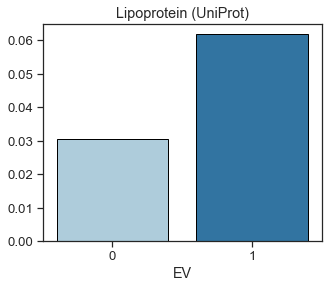

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
sns.barplot(x="EV", y='Lipoprotein_UP', data=df_all, edgecolor="black", ci=None)
ax.set(ylabel=None, title="Lipoprotein (UniProt)")
plt.show()

#fig.savefig(Figure_path + '/EV/Bar_plots_PTM_4_EV.png', dpi=150)

#### Rare PTMs

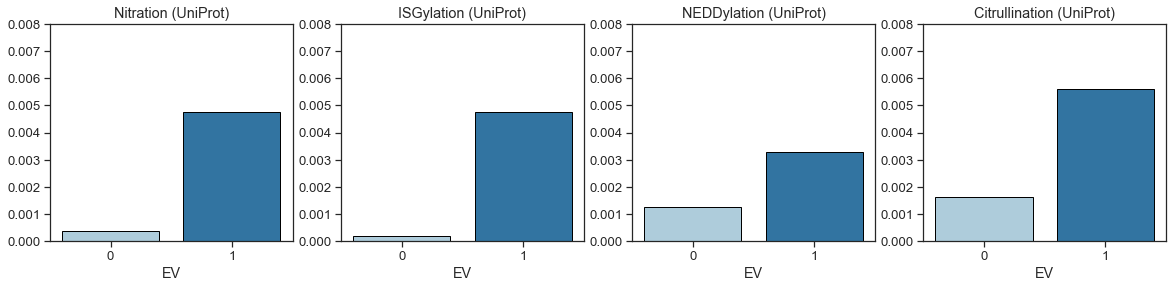

In [29]:
# other PTMs
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 4))
sns.barplot(x="EV", y='Nitration_UP', data=df_all, ax=ax1, edgecolor="black", ci=None)
ax1.set(ylabel=None, title="Nitration (UniProt)", ylim=(0, 0.008))
sns.barplot(x="EV", y='ISGylation_UP', data=df_all, ax=ax2, edgecolor="black", ci=None)
ax2.set(ylabel=None, title="ISGylation (UniProt)", ylim=(0, 0.008))
sns.barplot(x="EV", y='NEDDylation_UP', data=df_all, ax=ax3, edgecolor="black", ci=None)
ax3.set(ylabel=None, title="NEDDylation (UniProt)", ylim=(0, 0.008))
sns.barplot(x="EV", y='Citrullination_UP', data=df_all, ax=ax4, edgecolor="black", ci=None)
ax4.set(ylabel=None, title="Citrullination (UniProt)", ylim=(0, 0.008))
plt.show()

#fig.savefig(Figure_path + '/EV/Bar_plots_PTM_5_EV.png', dpi=150)

#### PTM predictions

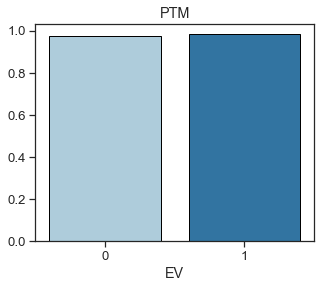

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
sns.barplot(x="EV", y='PTM_MSD', data=df_all, ax=ax, edgecolor="black", ci=None)
ax.set(ylabel=None, title="PTM")
plt.show()

#fig.savefig(Figure_path + '/EV/Bar_plots_PTM_prediction_1_EV.png', dpi=150)

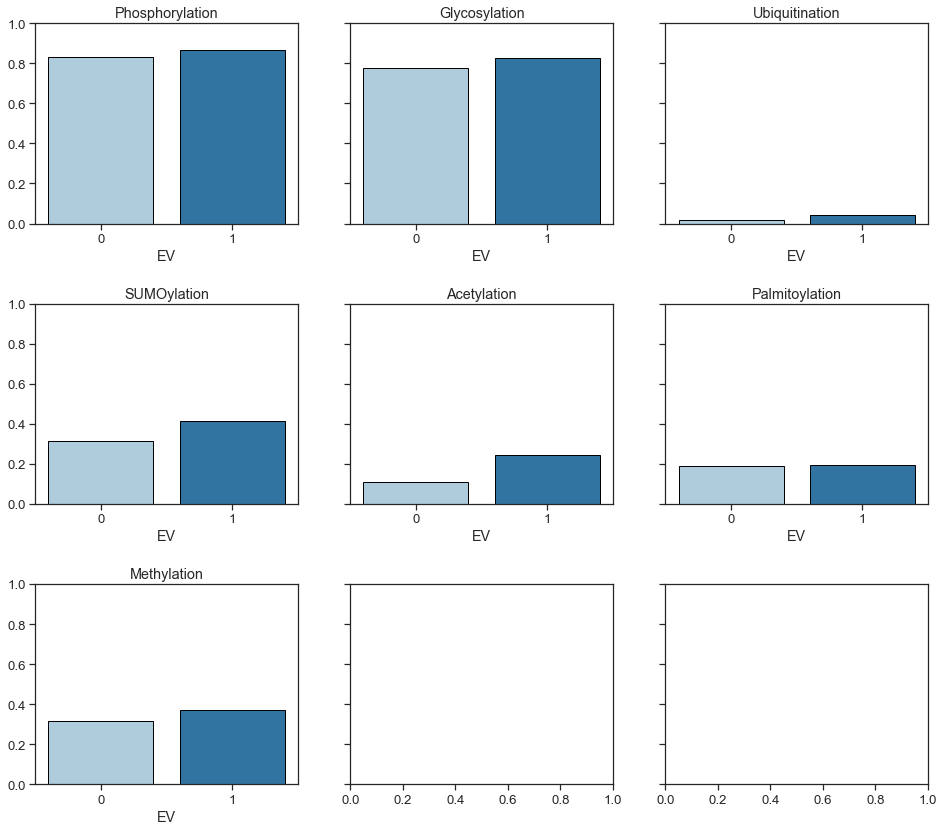

In [31]:
fig, axs = plt.subplots(3, 3, sharey=True, figsize=(16, 14))
plt.ylim((0,1))
sns.barplot(x="EV", y='Phosphorylation_MSD', data=df_all, ax=axs[0, 0], edgecolor="black", ci=None)
axs[0, 0].set(ylabel=None, title="Phosphorylation")
sns.barplot(x="EV", y='Glycosylation_MSD', data=df_all, ax=axs[0, 1], edgecolor="black", ci=None)
axs[0, 1].set(ylabel=None, title="Glycosylation")
sns.barplot(x="EV", y='Ubiquitination_MSD', data=df_all, ax=axs[0, 2], edgecolor="black", ci=None)
axs[0, 2].set(ylabel=None, title="Ubiquitination")
sns.barplot(x="EV", y='SUMOylation_MSD', data=df_all, ax=axs[1, 0], edgecolor="black", ci=None)
axs[1, 0].set(ylabel=None, title="SUMOylation")
sns.barplot(x="EV", y='Acetylation_MSD', data=df_all, ax=axs[1, 1], edgecolor="black", ci=None)
axs[1, 1].set(ylabel=None, title="Acetylation")
sns.barplot(x="EV", y='Palmitoylation_MSD', data=df_all, ax=axs[1, 2], edgecolor="black", ci=None)
axs[1, 2].set(ylabel=None, title="Palmitoylation")
sns.barplot(x="EV", y='Methylation_MSD', data=df_all, ax=axs[2, 0], edgecolor="black", ci=None)
axs[2, 0].set(ylabel=None, title="Methylation")
plt.subplots_adjust(hspace = 0.4)
plt.show()

#fig.savefig(Figure_path + '/EV/Bar_plots_PTM_prediction_2_EV.png', dpi=150)

#### Domains

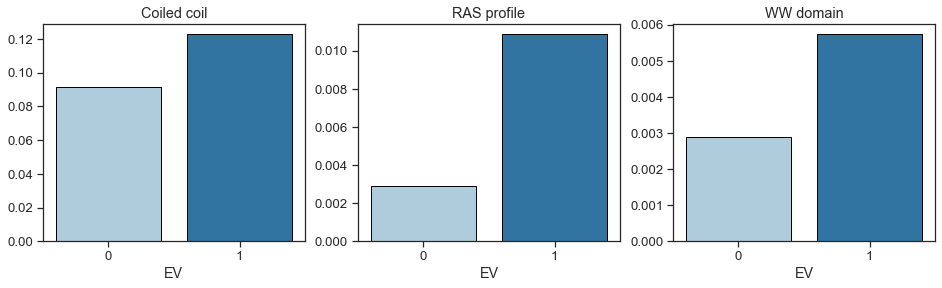

In [32]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 4))
sns.barplot(x="EV", y='coiled_coil', data=df_all, ax=ax1, edgecolor="black", ci=None)
ax1.set(ylabel=None, title="Coiled coil")
sns.barplot(x="EV", y='RAS_profile', data=df_all, ax=ax2, edgecolor="black", ci=None)
ax2.set(ylabel=None, title="RAS profile")
sns.barplot(x="EV", y='ww_domain', data=df_all, ax=ax3, edgecolor="black", ci=None)
ax3.set(ylabel=None, title="WW domain")
plt.show()

#fig.savefig(Figure_path + '/EV/Bar_plots_domains_EV.png', dpi=150)

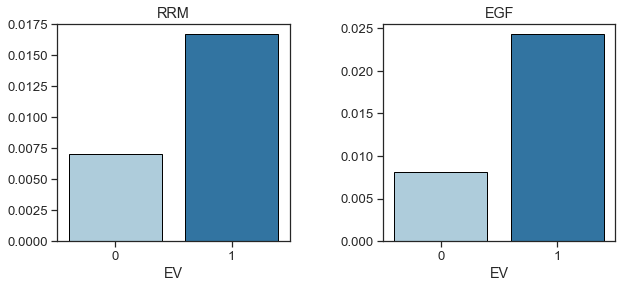

In [33]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
sns.barplot(x="EV", y='RRM', data=df_all, ax=ax1, edgecolor="black", ci=None)
ax1.set(ylabel=None, title="RRM")
sns.barplot(x="EV", y='EGF', data=df_all, ax=ax2, edgecolor="black", ci=None)
ax2.set(ylabel=None, title="EGF")
fig.subplots_adjust(wspace=0.4)
plt.show()

#fig.savefig(Figure_path + '/EV/Bar_plots_domains_EV_2.png', dpi=150)

#### Heat shock proteins

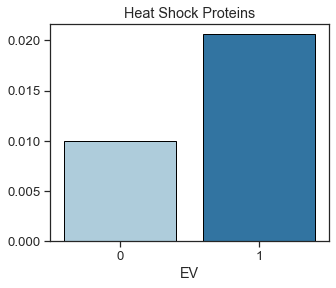

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
sns.barplot(x="EV", y="HSP", data=df_all, edgecolor="black", ci=None)
ax.set(ylabel=None, title="Heat Shock Proteins")
plt.show()

#fig.savefig(Figure_path + '/EV/Bar_plots_HSP_EV.png', dpi=150)

### PCA

In [35]:
df_all.columns[60:]

Index(['HSP', 'PTM_UP', 'Citrullination_UP', 'GPI-anchor_UP', 'Lipoprotein_UP',
       'Nitration_UP', 'Prenylation_UP', 'ISGylation_UP', 'NEDDylation_UP',
       'Acetylation_all', 'Glycosylation_all', 'Methylation_all',
       'Myristoylation_all', 'Nitrosylation_all', 'Palmitoylation_all',
       'Phosphorylation_all', 'SUMOylation_all', 'Ubiquitination_all',
       'PTM_MSD', 'Phosphorylation_MSD', 'Glycosylation_MSD',
       'Ubiquitination_MSD', 'SUMOylation_MSD', 'Acetylation_MSD',
       'Palmitoylation_MSD', 'Methylation_MSD', 'ww_domain', 'RAS_profile',
       'EGF', 'RRM', 'coiled_coil', 'transmembrane', 'TMHMM', 'Polar_exposed',
       'Hydrophobic_exposed', 'EV'],
      dtype='object')

In [36]:
features_continuous = ['length', 'hydr_count', 'polar_count', 'molecular_weight', 'helix', 'turn', 'sheet', 'A', 'C', 'D', 
                       'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y', 'thsa_netsurfp2',
                       'tasa_netsurfp2', 'rhsa_netsurfp2', 'disorder', 'A_exposed', 'C_exposed', 'D_exposed', 'E_exposed', 
                       'F_exposed', 'G_exposed', 'H_exposed', 'I_exposed', 'K_exposed', 'L_exposed', 'M_exposed', 'N_exposed', 
                       'P_exposed', 'Q_exposed', 'R_exposed', 'S_exposed', 'T_exposed', 'V_exposed', 'W_exposed', 'Y_exposed',
                       'Prob. of Solubility', 'Aggregation_propensity', 'Aromaticity', 'Instability_index', 'Gravy', 
                       'isoelectric_point', 'charge_at_7', 'charge_at_5', 'Polar_exposed', 'Hydrophobic_exposed', 'EV']

# scale data before PCA
df_pca = StandardScaler().fit_transform(df_all[features_continuous])
pca = PCA(n_components=2)
components = pca.fit_transform(df_pca)
# plot first two principal components
fig = px.scatter(components, x=0, y=1, color=df_all["EV"])
fig.show()